# Importazione librerie

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Lettura dati Bitcoin

In [16]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [17]:
# Bull market
# data_inizio = '2020-12-01'
# data_fine = '2021-04-30'

# Mercato laterale
# data_inizio = '2022-07-01'
# data_fine = '2022-10-31'

# Bear market
# data_inizio = '2021-05-01'
# data_fine = '2021-07-31'

# Periodo personale
data_inizio = '2021-02-01'
data_fine = '2021-07-01'

indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2021-02-01,27790.582031
1,2021-02-02,29501.521484
2,2021-02-03,31119.447266
3,2021-02-04,30859.554688
4,2021-02-05,31658.248047
...,...,...
146,2021-06-27,29013.742188
147,2021-06-28,28866.302734
148,2021-06-29,30139.980469
149,2021-06-30,29555.054688


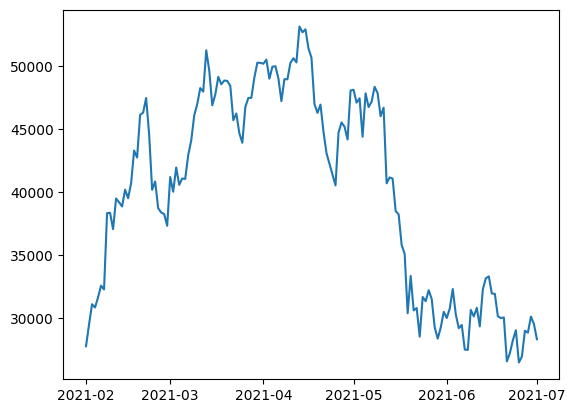

In [18]:
plt.plot(dati['Timestamp'], dati['Price'])

# Strategia

In [19]:
# Funzioni di supporto
def aggiorna_trailing_stop(prezzo, prezzo_TS, perc_TS):
    return (1 - perc_TS) * prezzo + perc_TS * prezzo_TS

def quanto_acquistare(liquidità_attuale):
    return 0.2 * liquidità_attuale

def quanto_vendere(bitcoin_posseduti):
    return bitcoin_posseduti

In [20]:
def strategia_trading(
    dati, 
    liquidità_iniziale, 
    bitcoin_iniziali, 
    perc_primo_acquisto, 
    perc_TS, 
    perc_TS_inverso_setting
):

    # Dati iniziali
    liquidità = liquidità_iniziale
    bitcoin = bitcoin_iniziali
    prezzo_TS = None
    prezzo_TS_inverso = None
    prezzo_minimo = None

    # Variabili di supporto
    prezzo_medio_acquisti = 0  # Media pesata dei prezzi degli acquisti
    quantità_acquisti = 0  # Quantità totale di BTC acquistati nella scia attuale
    valore_totale_acquisti = 0  # Valore totale degli acquisti effettuati
    in_scia_acquisti = False  # Flag per controllare se siamo in una scia di acquisti
    ultima_azione = "-"
    oltre_TS = False

    # Lista per registrare le transazioni
    transazioni = []

    # Itera sui dati
    for _, row in dati.iterrows():
        prezzo = row["Price"]
        timestamp = row["Timestamp"]
        azione = "-"
        liquidità_spesa_o_guadagnata = 0
        bitcoin_comprati_o_venduti = 0

        # Aggiorna il prezzo minimo nella scia corrente
        if in_scia_acquisti:
            if prezzo_minimo is None or prezzo < prezzo_minimo:
                prezzo_minimo = prezzo
                prezzo_TS_inverso = min(
                    prezzo * (1 + perc_TS_inverso_setting),
                    prezzo_medio_acquisti
                )

        # Controlla se l'acquisto è un "primo acquisto"
        if ultima_azione == "Vendita" or ultima_azione == "-":
            # Primo acquisto
            quantità_acquisto = perc_primo_acquisto * liquidità / prezzo
            liquidità_spesa_o_guadagnata = quantità_acquisto * prezzo
            liquidità -= liquidità_spesa_o_guadagnata
            bitcoin_comprati_o_venduti = quantità_acquisto
            bitcoin += bitcoin_comprati_o_venduti
            prezzo_medio_acquisti = prezzo
            valore_totale_acquisti = quantità_acquisto * prezzo
            quantità_acquisti = quantità_acquisto
            prezzo_TS = prezzo_medio_acquisti * (1 + perc_TS)
            prezzo_minimo = prezzo
            prezzo_TS_inverso = min(prezzo_minimo * (1 + perc_TS_inverso_setting), prezzo_medio_acquisti) # in realtà al primo acquisto è ovvio che venga uguale a prezzo_medio_acquisti, quindi il calcolo del minimo è superfluo
            in_scia_acquisti = True
            ultima_azione = "Acquisto"
            azione = "Acquisto"

        elif in_scia_acquisti:
            # Controlla se effettuare un acquisto in scia
            if prezzo < prezzo_medio_acquisti:
                if prezzo < prezzo_TS and prezzo >= prezzo_TS_inverso:
                    # Acquisto in scia
                    quantità_acquisto = quanto_acquistare(liquidità) / prezzo
                    liquidità_spesa_o_guadagnata = quantità_acquisto * prezzo
                    liquidità -= liquidità_spesa_o_guadagnata
                    bitcoin_comprati_o_venduti = quantità_acquisto
                    bitcoin += bitcoin_comprati_o_venduti
                    valore_totale_acquisti += liquidità_spesa_o_guadagnata
                    quantità_acquisti += quantità_acquisto
                    prezzo_medio_acquisti = valore_totale_acquisti / quantità_acquisti
                    prezzo_TS = prezzo_medio_acquisti * (1 + perc_TS)
                    azione = "Acquisto"

        # Controlla se effettuare una vendita
        if prezzo > prezzo_TS:
            prezzo_TS = aggiorna_trailing_stop(prezzo, prezzo_TS, perc_TS)
            oltre_TS = True
        elif oltre_TS:
            # Vendita
            quantità_vendita = quanto_vendere(bitcoin)
            liquidità_spesa_o_guadagnata = quantità_vendita * prezzo
            liquidità += liquidità_spesa_o_guadagnata
            bitcoin_comprati_o_venduti = -quantità_vendita
            bitcoin += bitcoin_comprati_o_venduti
            azione = "Vendita"
            prezzo_TS = None
            prezzo_TS_inverso = None
            prezzo_minimo = None
            prezzo_medio_acquisti = 0
            quantità_acquisti = 0
            valore_totale_acquisti = 0
            in_scia_acquisti = False
            ultima_azione = "Vendita"
            oltre_TS = False

        # Valore totale del portafoglio
        valore_totale_portafoglio = liquidità + bitcoin * prezzo

        # Registra la transazione
        transazioni.append({
            "timestamp": timestamp,
            "prezzo": prezzo,
            "prezzo_TS": prezzo_TS,
            "prezzo_TS_inverso": prezzo_TS_inverso,
            "ultima_azione": ultima_azione,
            "azione": azione,
            "liquidità_spesa_o_guadagnata": liquidità_spesa_o_guadagnata,
            "bitcoin_comprati_o_venduti": bitcoin_comprati_o_venduti,
            "liquidità_posseduta": liquidità,
            "bitcoin_posseduti": bitcoin,
            "valore_totale_portafoglio": valore_totale_portafoglio,
        })

    # Converti la lista di transazioni in un dataframe
    df_transazioni = pd.DataFrame(transazioni)
    return df_transazioni

In [39]:
df_transazioni = strategia_trading(
    dati,
    liquidità_iniziale=0.01,
    bitcoin_iniziali=0.02478146,
    perc_primo_acquisto=0.1,
    perc_TS=0,
    perc_TS_inverso_setting=0.05
)

df_transazioni

,timestamp,prezzo,prezzo_TS,prezzo_TS_inverso,ultima_azione,azione,liquidità_spesa_o_guadagnata,bitcoin_comprati_o_venduti,liquidità_posseduta,bitcoin_posseduti,valore_totale_portafoglio
0,2021-02-01,27790.582031,27790.582031,27790.582031,Acquisto,Acquisto,0.001000,3.598341e-08,0.009000,0.024781,688.701197
1,2021-02-02,29501.521484,29501.521484,27790.582031,Acquisto,-,0.000000,0.000000e+00,0.009000,0.024781,731.100836
2,2021-02-03,31119.447266,31119.447266,27790.582031,Acquisto,-,0.000000,0.000000e+00,0.009000,0.024781,771.195457
3,2021-02-04,30859.554688,NaN,NaN,Vendita,Vendita,764.745931,-2.478150e-02,764.754931,0.000000,764.754931
4,2021-02-05,31658.248047,31658.248047,31658.248047,Acquisto,Acquisto,76.475493,2.415658e-03,688.279437,0.002416,764.754931
...,...,...,...,...,...,...,...,...,...,...,...
146,2021-06-27,29013.742188,29265.597942,27827.983887,Acquisto,Acquisto,90.658611,3.124678e-03,362.634444,0.014499,783.315359
147,2021-06-28,28866.302734,29206.625417,27827.983887,Acquisto,Acquisto,72.526889,2.512510e-03,290.107555,0.017012,781.177580
148,2021-06-29,30139.980469,30139.980469,27827.983887,Acquisto,-,0.000000,0.000000e+00,290.107555,0.017012,802.845231
149,2021-06-30,29555.054688,NaN,NaN,Vendita,Vendita,502.786990,-1.701188e-02,792.894545,0.000000,792.894545


In [40]:
df_transazioni['valore_totale_portafoglio'].iloc[-1] / df_transazioni['valore_totale_portafoglio'].iloc[0]

np.float64(1.1512896278341151)